In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as SKLDA
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, f1_score,
    mean_absolute_error, mean_squared_error, r2_score
)

from scipy import stats

sns.set_style("whitegrid")


In [19]:
df = pd.read_csv("AswanData_weatherdata.csv")

df.drop("Date", axis=1, inplace=True)

# Binning (Target Engineering)
df["Solar_Class"] = pd.qcut(
    df["Solar(PV)"], q=3, labels=["Low", "Medium", "High"]
)
df.drop("Solar(PV)", axis=1, inplace=True)

X = df.drop("Solar_Class", axis=1)
y = df["Solar_Class"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

print("Encoded Classes:", class_names)


Encoded Classes: ['High' 'Low' 'Medium']


In [20]:
# Missing values treatment
for col in X.columns:
    X[col].fillna(X[col].mean(), inplace=True)

# Statistics
stats_df = pd.DataFrame({
    "Min": X.min(),
    "Max": X.max(),
    "Mean": X.mean(),
    "Variance": X.var(),
    "Std": X.std(),
    "Skewness": X.skew(),
    "Kurtosis": X.kurt()
})

print(stats_df)


                                 Min    Max        Mean      Variance  \
Unnamed: 0                       0.0  421.0  211.439698  15044.403156   
AvgTemperture                   51.1  102.7   81.846482    185.316398   
AverageDew(point via humidity)  15.3   63.9   36.754020     79.331709   
Humidity                         7.4   47.7   22.968090     95.191196   
Wind                             4.4   17.1   10.146734      6.295846   
Pressure                        28.9   29.6   29.183040      0.019668   

                                       Std  Skewness  Kurtosis  
Unnamed: 0                      122.655628 -0.020326 -1.210674  
AvgTemperture                    13.613097 -0.528708 -0.903930  
AverageDew(point via humidity)    8.906835  0.001333 -0.667801  
Humidity                          9.756598  0.731028 -0.414197  
Wind                              2.509152  0.223224 -0.182979  
Pressure                          0.140241  0.448676 -0.633823  


C:\Users\moham\AppData\Local\Temp\ipykernel_19492\2440090548.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].mean(), inplace=True)


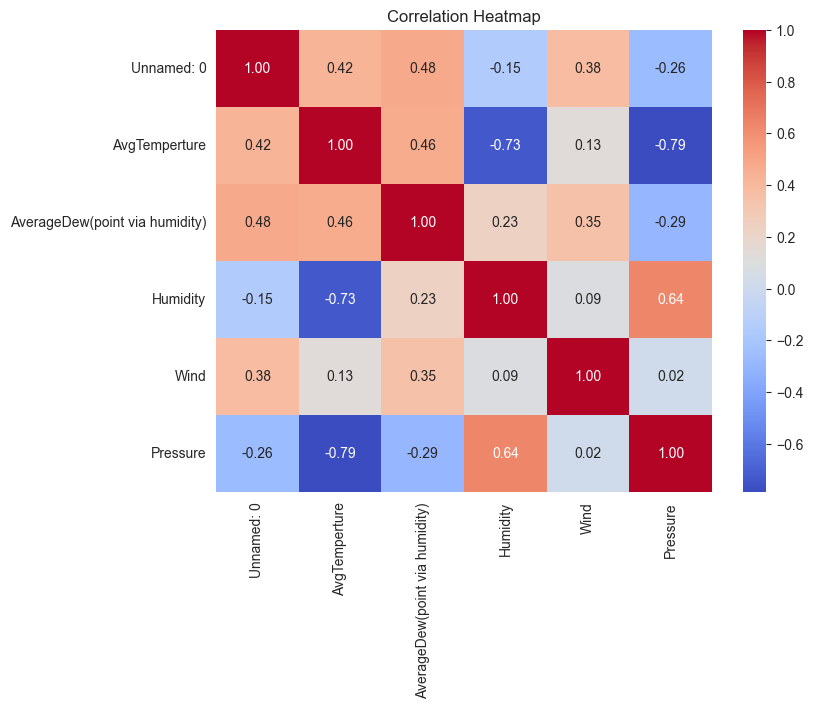

In [21]:
cov_matrix = X.cov()
corr_matrix = X.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [22]:
# ANOVA
for col in X.columns:
    groups = [df[df["Solar_Class"] == c][col] for c in class_names]
    f, p = stats.f_oneway(*groups)
    print(f"{col} | ANOVA p-value = {p:.4f}")

# Chi-Square (Discretized feature)
disc_feature = pd.qcut(X.iloc[:,0], q=3)
chi2, p, _, _ = stats.chi2_contingency(
    pd.crosstab(disc_feature, y)
)
print("Chi-square p-value:", p)


Unnamed: 0 | ANOVA p-value = 0.0000
AvgTemperture | ANOVA p-value = 0.0347
AverageDew(point via humidity) | ANOVA p-value = 0.5415
Humidity | ANOVA p-value = 0.0044
Wind | ANOVA p-value = 0.0000
Pressure | ANOVA p-value = 0.3805
Chi-square p-value: 1.5483916641706808e-37


In [23]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Kernel PCA
kpca = KernelPCA(n_components=2, kernel="rbf")
X_kpca = kpca.fit_transform(X_scaled)

# LDA
lda = SKLDA(n_components=2)
X_lda = lda.fit_transform(X_scaled, y_encoded)

# SVD
svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(X_scaled)


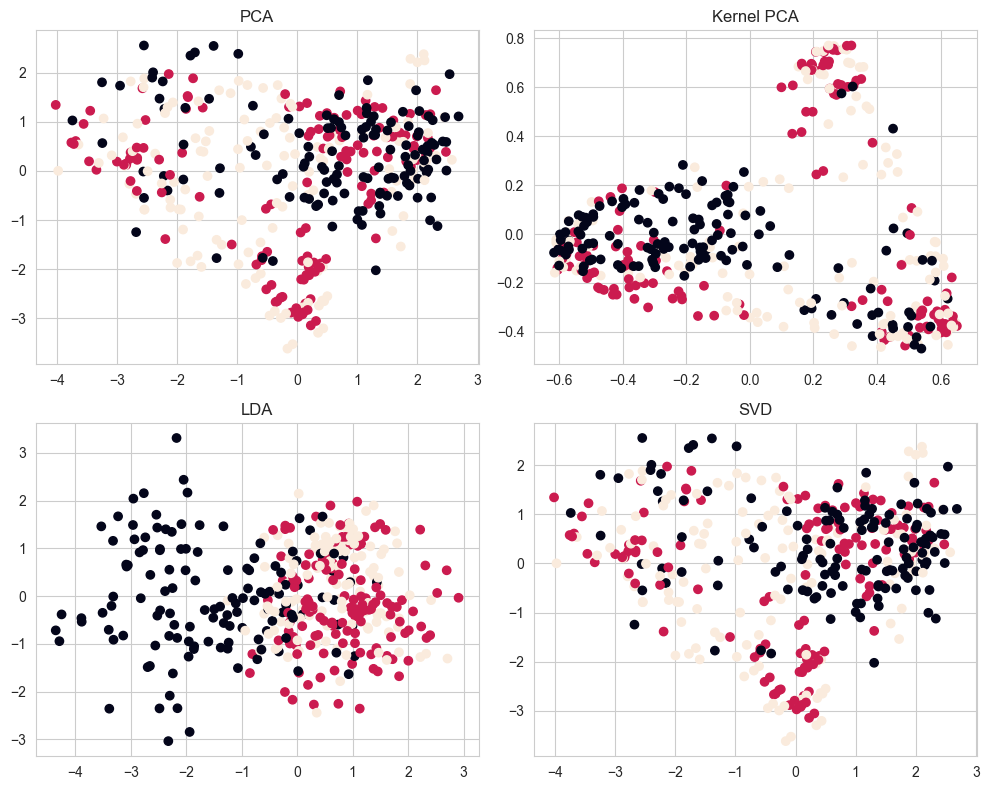

In [24]:
fig, axs = plt.subplots(2,2, figsize=(10,8))

axs[0,0].scatter(X_pca[:,0], X_pca[:,1], c=y_encoded)
axs[0,0].set_title("PCA")

axs[0,1].scatter(X_kpca[:,0], X_kpca[:,1], c=y_encoded)
axs[0,1].set_title("Kernel PCA")

axs[1,0].scatter(X_lda[:,0], X_lda[:,1], c=y_encoded)
axs[1,0].set_title("LDA")

axs[1,1].scatter(X_svd[:,0], X_svd[:,1], c=y_encoded)
axs[1,1].set_title("SVD")

plt.tight_layout()
plt.show()


In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

kfold = KFold(n_splits=10, shuffle=True, random_state=42)


In [26]:
models = {
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(criterion="entropy"),
    "KNN Euclidean": KNeighborsClassifier(p=2),
    "KNN Manhattan": KNeighborsClassifier(p=1),
    "LDA Classifier": SKLDA(),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(50,), max_iter=500),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}


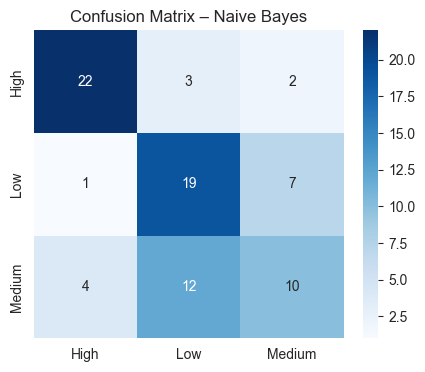

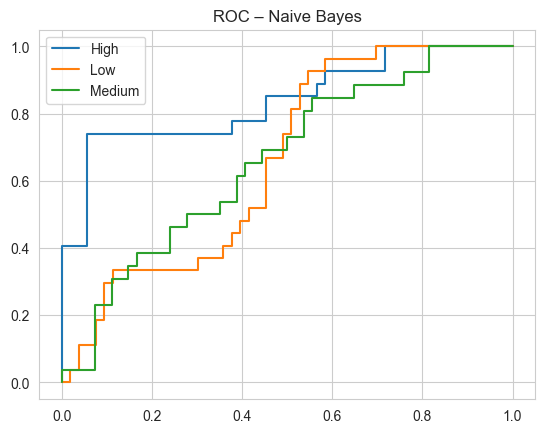

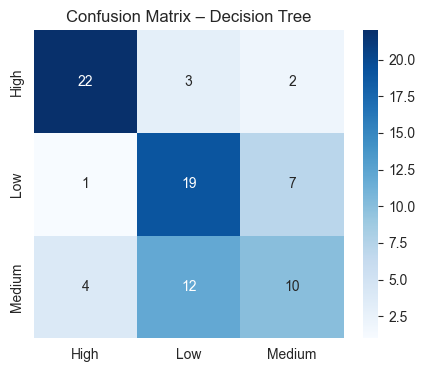

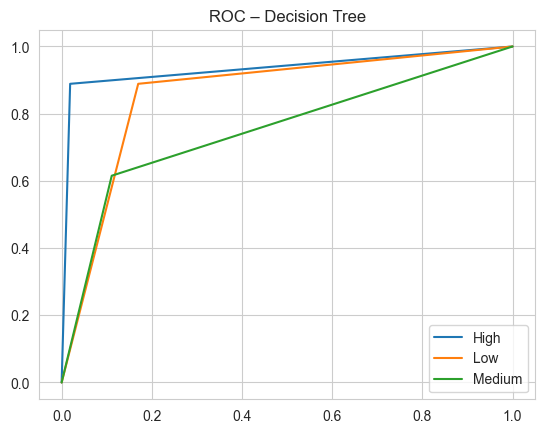

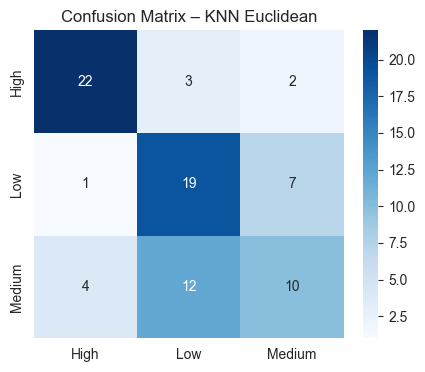

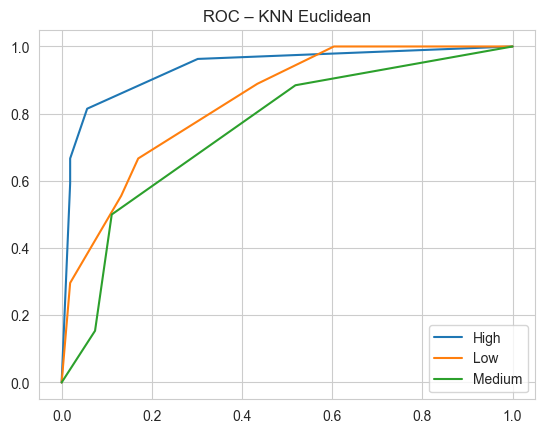

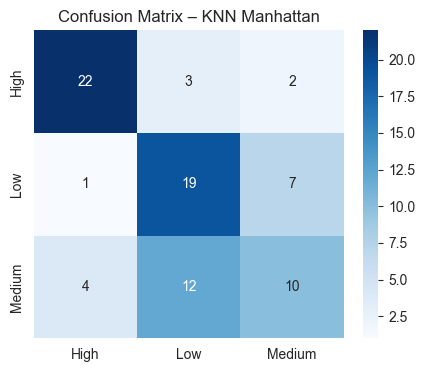

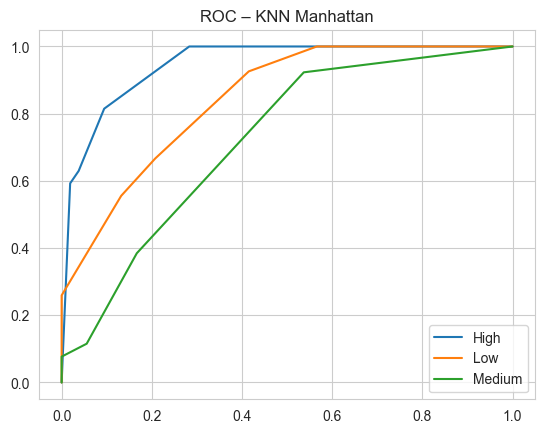

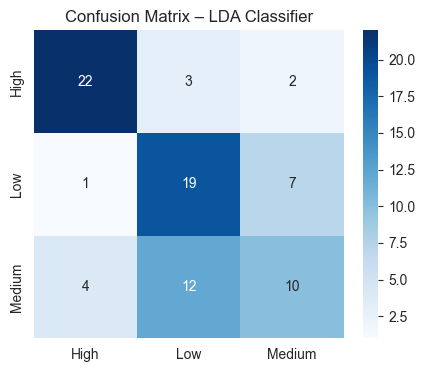

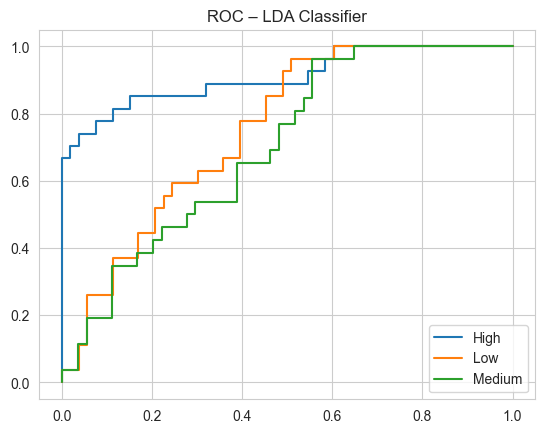

c:\Users\moham\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


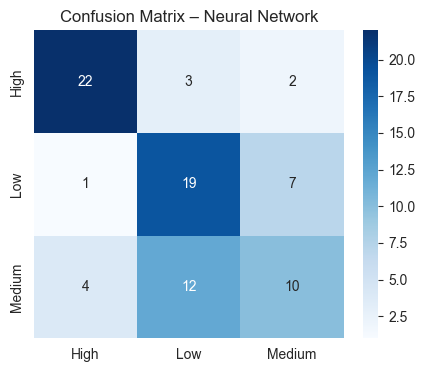

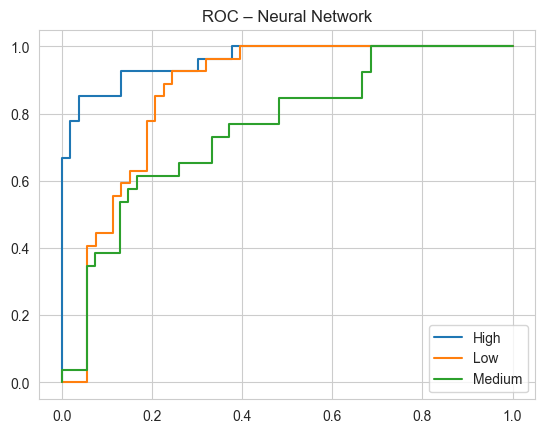

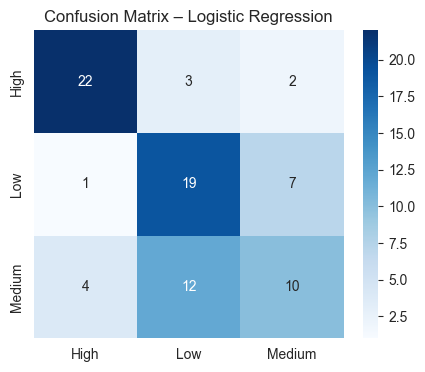

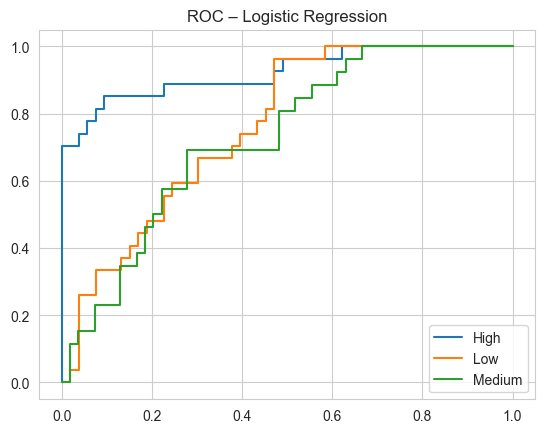

In [27]:
results = {}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")
    
    # Save results as a dictionary for all models
    results[name] = {
        'Test_Accuracy': acc,
        'F1_Score': f1
    }

    # Confusion Matrix Visualization
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f"Confusion Matrix – {name}")
    plt.show()

    # ROC Curve
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)
        plt.figure()
        for i in range(len(class_names)):
            fpr, tpr, _ = roc_curve((y_test==i).astype(int), y_prob[:,i])
            plt.plot(fpr, tpr, label=class_names[i])
        plt.legend()
        plt.title(f"ROC – {name}")
        plt.show()


In [28]:
y_reg = df["Solar_Class"].cat.codes

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

pred = lin_reg.predict(X_test)

print("MAE:", mean_absolute_error(y_test, pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred)))
print("R2:", r2_score(y_test, pred))


MAE: 0.5358683848915782
RMSE: 0.6465259778339918
R2: 0.36891404196959765


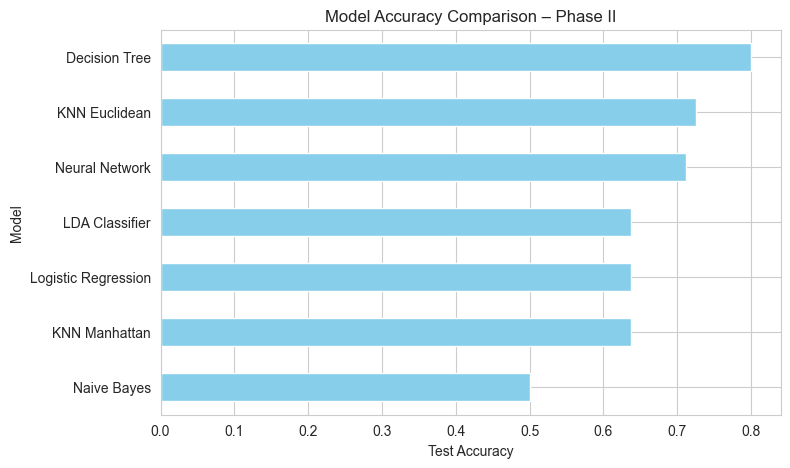

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract Test_Accuracy from results dictionary
accuracy_dict = {name: v['Test_Accuracy'] for name, v in results.items()}

# Convert to pandas Series and plot
plt.figure(figsize=(8,5))
pd.Series(accuracy_dict).sort_values().plot(kind="barh", color='skyblue')
plt.title("Model Accuracy Comparison – Phase II")
plt.xlabel("Test Accuracy")
plt.ylabel("Model")
plt.show()


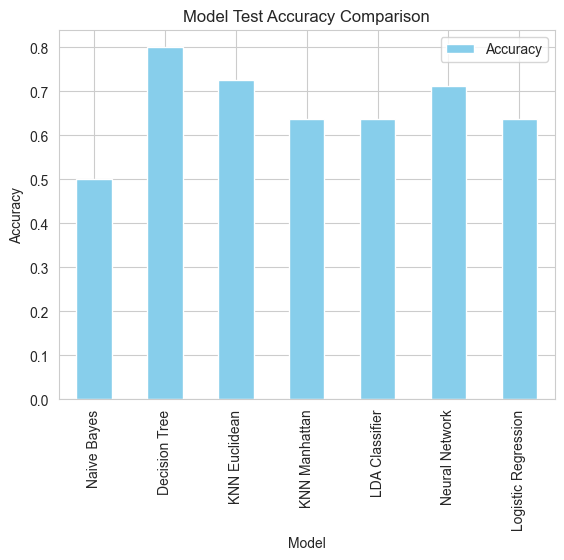

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [v['Test_Accuracy'] for v in results.values()],
    'F1_Score': [v['F1_Score'] for v in results.values()]
})
metrics_df.plot(x='Model', y='Accuracy', kind='bar', color='skyblue')
plt.title("Model Test Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()


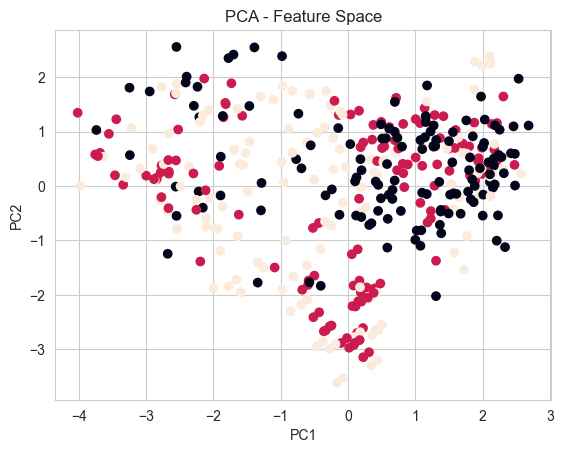

In [32]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_encoded)
plt.title("PCA - Feature Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


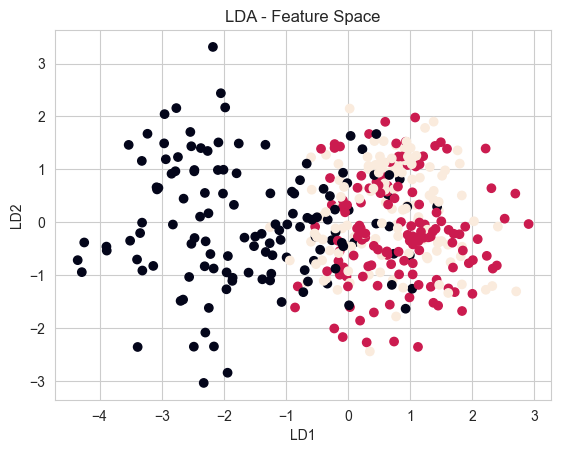

In [33]:
plt.scatter(X_lda[:,0], X_lda[:,1], c=y_encoded)
plt.title("LDA - Feature Space")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.show()
